# Interactions between ProTα and Histone H1.0 evolution variants

In [2]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Topologies

#### Compact frames

In [2]:
# Loading trajectories
trajs = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    trajs[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

In [3]:
# Saving most compact frame as topology
for variant, traj in trajs.items():
    compact_frame = analyse_utils.compact_frame(traj)
    compact_frame.save_pdb(f'data/{variant}.pdb')

#### Merging

In [4]:
# Loading topologies
H10_vars = {}
ProTa = None
data_path = 'data'
for file in os.listdir(data_path):
    if '.pdb' in file:
        traj = md.load(f'{data_path}/{file}')

        id = file[:-4]
        if ('H1-0_VAR' in id) and ('PROTA_WT' not in id):
            H10_vars[id] = traj

        elif 'PROTA_WT' == id:
            ProTa = traj

print(H10_vars.keys())

dict_keys(['H1-0_VAR_Rg4.09_k0.19', 'H1-0_VAR_Rg4.07_k0.25', 'H1-0_VAR_Rg3.82_k0.45', 'H1-0_VAR_Rg4.18_k0.27', 'H1-0_VAR_Rg3.46_k0.58', 'H1-0_VAR_Rg3.87_k0.26', 'H1-0_VAR_Rg3.76_k0.38', 'H1-0_VAR_Rg3.89_k0.34', 'H1-0_VAR_Rg3.72_k0.49', 'H1-0_VAR_Rg3.62_k0.42', 'H1-0_VAR_Rg4.23_k0.22', 'H1-0_VAR_Rg3.88_k0.37', 'H1-0_VAR_Rg3.95_k0.32', 'H1-0_VAR_Rg3.74_k0.42', 'H1-0_VAR_Rg4.05_k0.30', 'H1-0_VAR_Rg4.19_k0.21', 'H1-0_VAR_Rg3.89_k0.29', 'H1-0_VAR_Rg3.63_k0.54', 'H1-0_VAR_Rg3.65_k0.47', 'H1-0_VAR_Rg3.97_k0.25', 'H1-0_VAR_Rg4.24_k0.26', 'H1-0_VAR_Rg4.03_k0.20', 'H1-0_VAR_Rg4.02_k0.26', 'H1-0_VAR_Rg3.94_k0.22', 'H1-0_VAR_Rg3.83_k0.39', 'H1-0_VAR_Rg3.87_k0.42', 'H1-0_VAR_Rg3.72_k0.54', 'H1-0_VAR_Rg4.20_k0.17', 'H1-0_VAR_Rg4.26_k0.23', 'H1-0_VAR_Rg3.94_k0.28', 'H1-0_VAR_Rg3.43_k0.62', 'H1-0_VAR_Rg3.99_k0.22', 'H1-0_VAR_Rg4.15_k0.18', 'H1-0_VAR_Rg3.68_k0.41', 'H1-0_VAR_Rg3.92_k0.25', 'H1-0_VAR_Rg3.72_k0.36', 'H1-0_VAR_Rg4.27_k0.33', 'H1-0_VAR_Rg3.85_k0.30', 'H1-0_VAR_Rg4.24_k0.18', 'H1-0_VAR_Rg3.

In [5]:
# Making sets of topologies
twochain_sets = [[H10_var, ProTa] for H10_var in H10_vars.values()]

In [6]:
# Translating topologies
for tc_set  in twochain_sets:
    translate_x = 10 # nm
    translate_y = 0 # nm
    translate_z = 0 # nm
    for i, traj in enumerate(tc_set):
        traj.center_coordinates()
        traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [7]:
# Merging topologies
boxlength = 25 # nm
tc_merges = [simulate_utils.merge_topologies(tc_set, boxlength=boxlength) for tc_set in twochain_sets]
for traj in tc_merges:
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

In [8]:
# Saving merged topologies
for traj, H10_var_id in zip(tc_merges, H10_vars.keys()):
    filename = f'data/{H10_var_id}_PROTA_WT_{boxlength}nm.pdb'
    traj.save(filename)

## Analysis

### Two chain (Rg-kappa variants)

#### $K_d$

In [10]:
# Loading precalculated energy data
datas = []
resultsdir = "results/two_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
    data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
    data['Rg'] = float(variant[11:15])
    data['kappa'] = float(variant[17:21])
    datas.append(data)
data = pd.concat(datas)
data

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol],Rg
0,0.630127,-5.144418,0.560969,2.231662,-4.514291,3.61
1,-1.661506,-21.031152,0.517092,1.441419,-22.692659,3.61
2,-1.633053,-1.177342,0.498834,1.725736,-2.810395,3.61
3,-7.488335,-7.651785,0.604542,2.027362,-15.140120,3.61
4,-4.137360,-10.166481,0.597201,2.016862,-14.303840,3.61
...,...,...,...,...,...,...
31995,1.599528,4.963128,0.534855,2.525124,6.562656,3.96
31996,0.108459,1.246626,0.504160,2.494693,1.355085,3.96
31997,-5.452720,-1.556448,0.473883,2.316196,-7.009168,3.96
31998,5.274651,1.567478,0.534337,2.234110,6.842130,3.96


Rg
3.44    <matplotlib.collections.PathCollection object ...
3.50    <matplotlib.collections.PathCollection object ...
3.56    <matplotlib.collections.PathCollection object ...
3.61    <matplotlib.collections.PathCollection object ...
3.66    <matplotlib.collections.PathCollection object ...
3.72    <matplotlib.collections.PathCollection object ...
3.75    <matplotlib.collections.PathCollection object ...
3.79    <matplotlib.collections.PathCollection object ...
3.83    <matplotlib.collections.PathCollection object ...
3.86    <matplotlib.collections.PathCollection object ...
3.90    <matplotlib.collections.PathCollection object ...
3.93    <matplotlib.collections.PathCollection object ...
3.96    <matplotlib.collections.PathCollection object ...
3.99    <matplotlib.collections.PathCollection object ...
4.03    <matplotlib.collections.PathCollection object ...
4.07    <matplotlib.collections.PathCollection object ...
4.15    <matplotlib.collections.PathCollection object ...
4.19    <ma

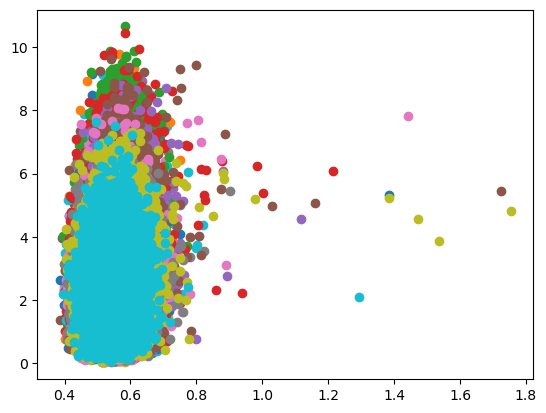

In [19]:
data.groupby('Rg').apply(lambda df: plt.scatter(df['Minimum interresidue distance [nm]'], df['Center of mass distance [nm]']))

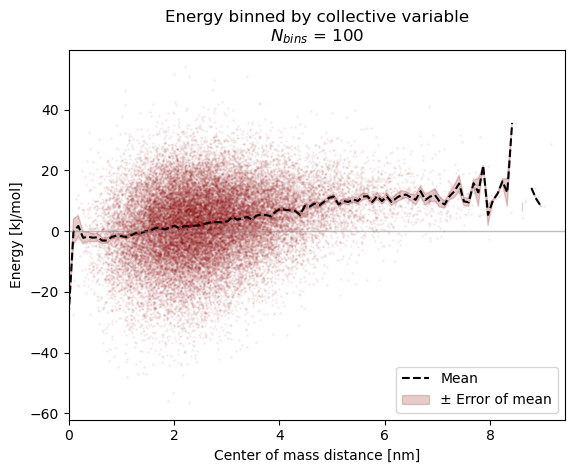

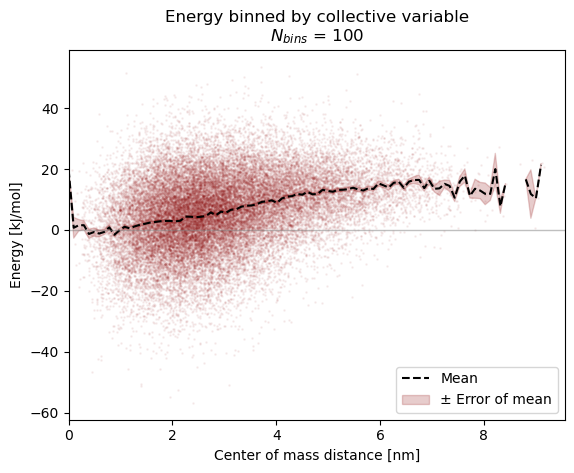

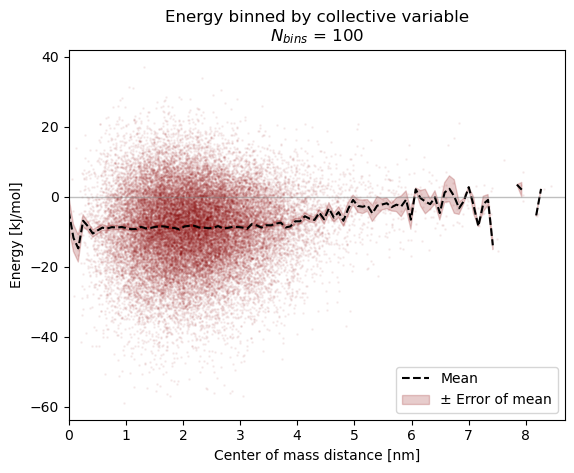

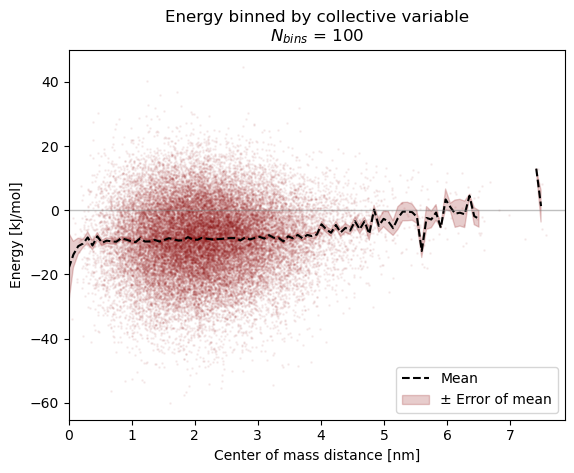

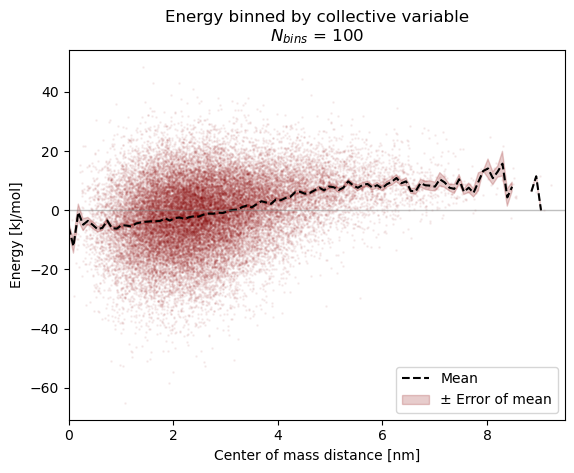

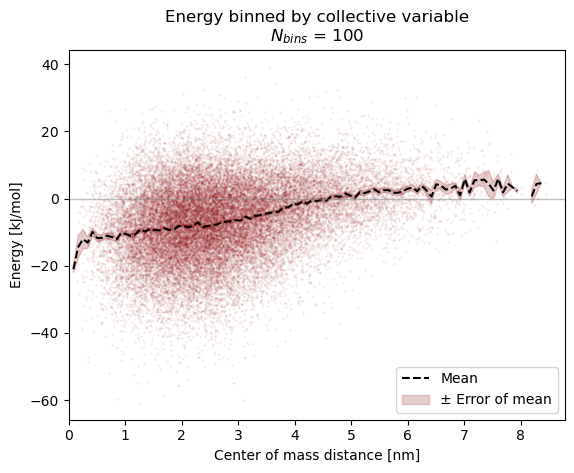

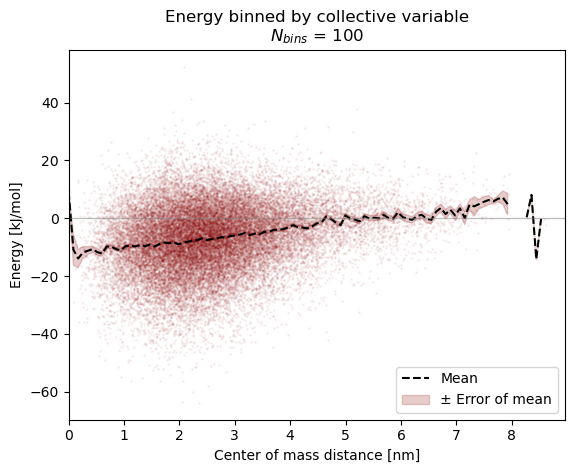

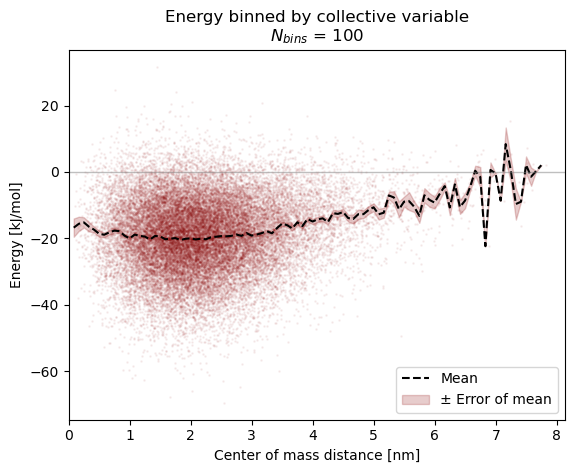

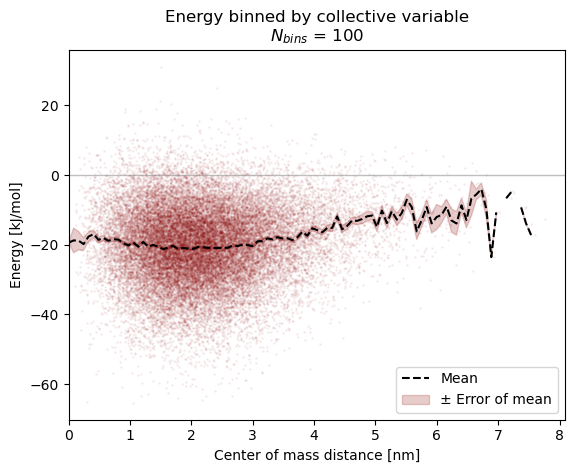

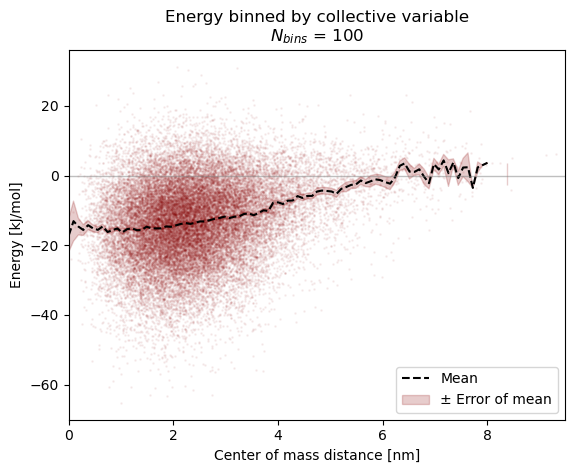

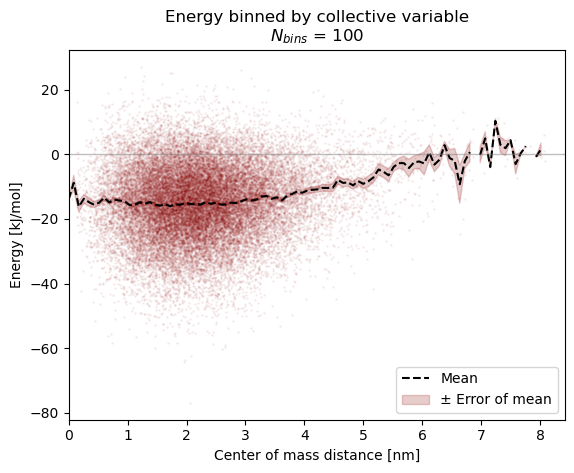

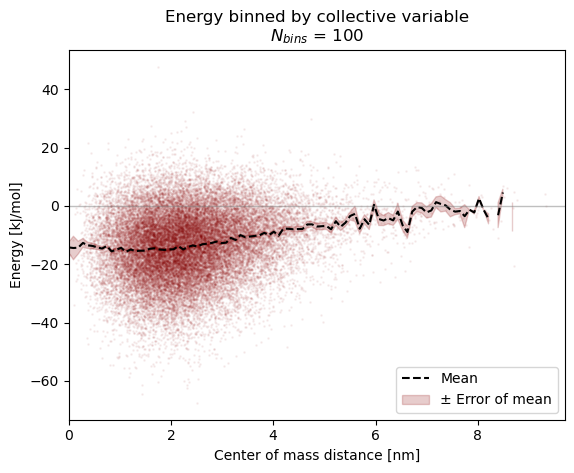

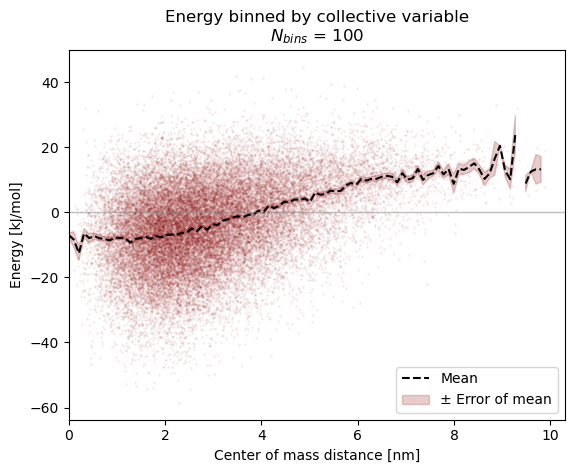

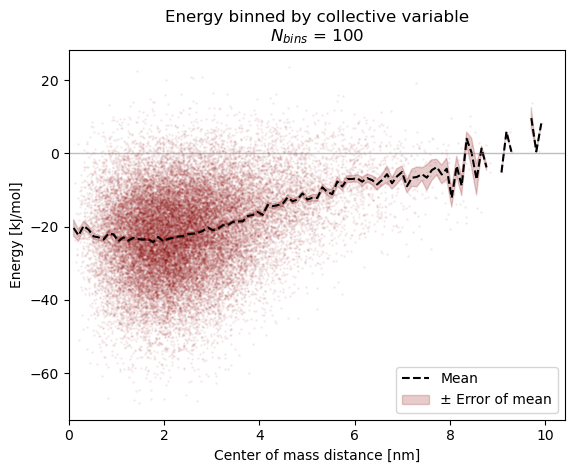

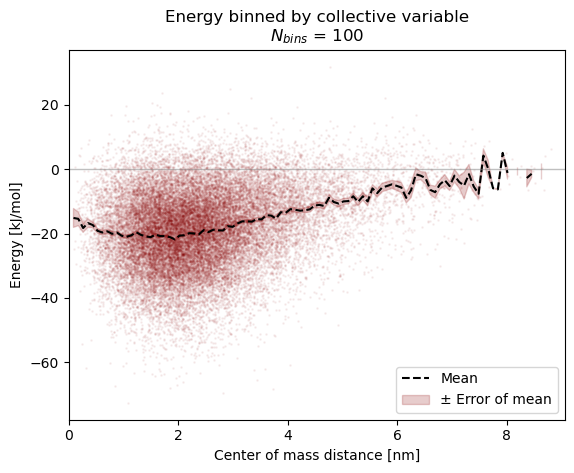

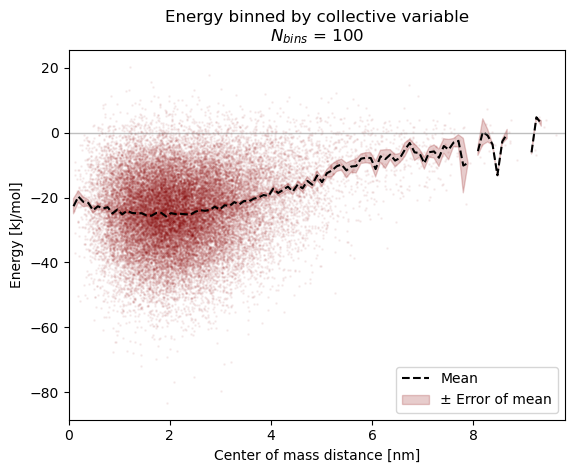

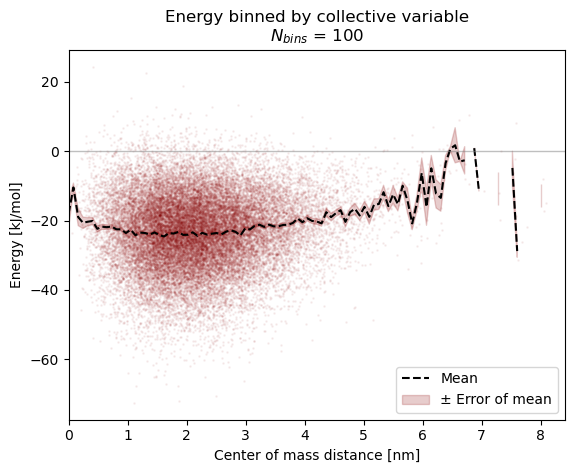

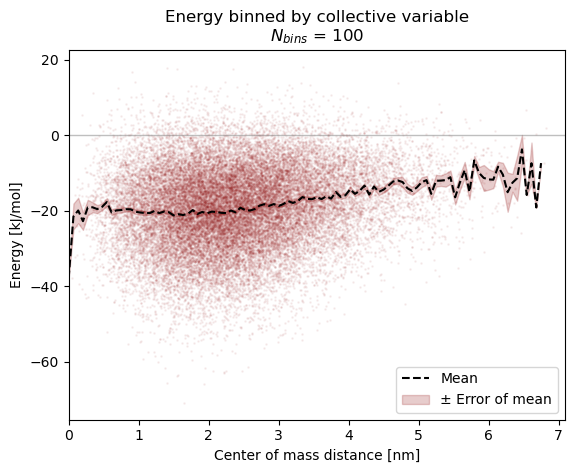

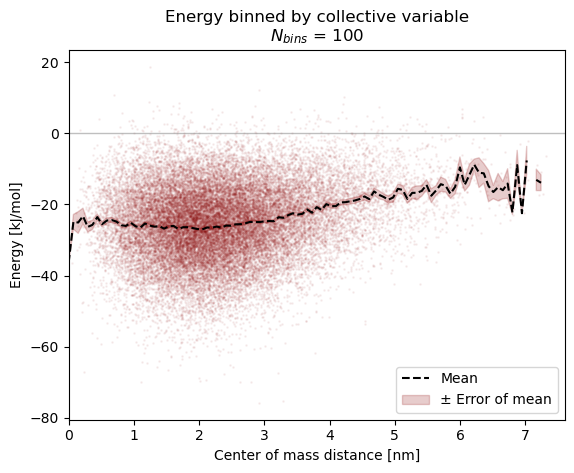

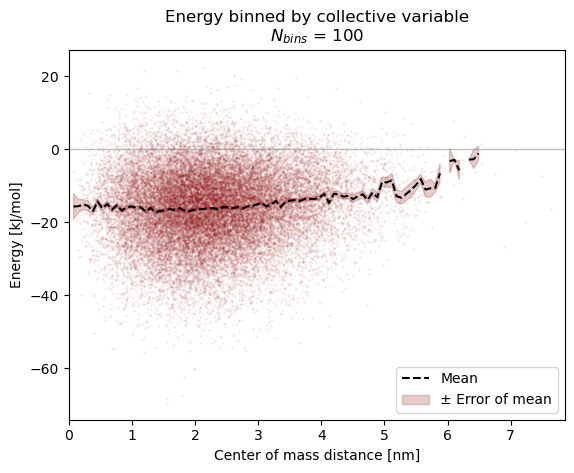

In [11]:
Kds = data.groupby('Rg').apply(lambda df: analyse_utils.compute_Kd(df['Total energy [kJ/mol]'], df['Center of mass distance [nm]'], 298, 100))

Text(0, 0.5, '$log_{10}(K_d)$')

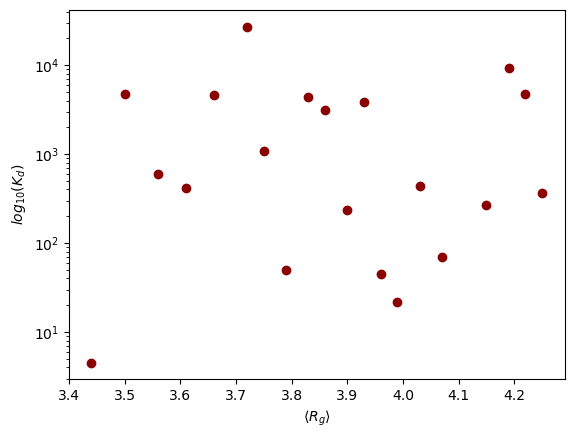

In [25]:
plt.scatter(Kds.index, Kds, color='darkred')
plt.yscale('log')
plt.xlabel('$\left\langle R_g \\right\\rangle$')
plt.ylabel('$log_{10}(K_d)$')

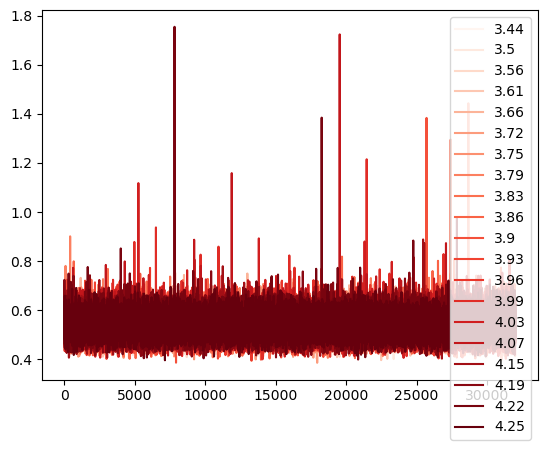

In [17]:
cmap = plt.cm.Reds
Rg_min = data.Rg.min()
Rg_max = data.Rg.max()
data.groupby('Rg').apply(lambda df: plt.plot(df['Minimum interresidue distance [nm]'], label=round(df['Rg'].min(),2), color=cmap((df['Rg'].min()-Rg_min)/(Rg_max-Rg_min))))
plt.legend(loc='upper right')

### Combining all two-chain data

In [3]:
from conditions import conditions

all_Kd = pd.read_csv('all_Kd.csv', index_col=0)
tc_dirs = ['../prota_variant_comb/results/two_chain',
           '../prota_variant_k/results/two_chain',
           '../prota_variant_rg/results/two_chain',
           '../prota_h1-0/results/two_chain_25nm']

# Looping over two chain simulations
for tc_dir in tc_dirs:
    for cond in os.listdir(tc_dir):
        for top in os.listdir(f'{tc_dir}/{cond}'):
            origin=f'{tc_dir[3:]}/{cond}/{top}'

            if origin in all_Kd.origin.values:
                print('Skipping (Already calculated)', origin)
            
            else:
                # From precalculated data
                interaction = pd.read_csv(f'../{origin}/interaction_energy.csv')
                Kd = analyse_utils.compute_Kd(interaction['Ashbaugh-Hatch [kJ/mol]']+interaction['Debye-Hückel [kJ/mol]'], interaction['Center of mass distance [nm]'], conditions.loc[cond].temp, 100, plot=False)
                sampled_unbinding = any(interaction['Minimum interresidue distance [nm]'] > 4)

                # From sequence
                if 'H1-0_PROTA_WT_25nm' in origin:
                    single_chain_dir = f'{tc_dir}/../single_chain/default/H1-0_WT'
                else:
                    single_chain_dir = f'{tc_dir}/../single_chain/default/{top[:-14]}'
                traj = md.load_dcd(f'{single_chain_dir}/traj.dcd', f'{single_chain_dir}/top.pdb')
                res = simulate_utils.extract_sequences(traj.top)
                seq = ''.join(res[res.chain==0].aa)
                kappa = analyse_utils.SequenceParameters(seq).get_kappa()
                ionic = conditions.loc[cond].ionic

                # From single-chain default condition trajectory (From first 3300 frames / ~ 1 µs)
                Rg = analyse_utils.compute_rg(traj[:3300]).mean()
                Delta = analyse_utils.compute_asphericity(traj[:3300])
                S = analyse_utils.compute_prolateness(traj[:3300])
                nu = analyse_utils.compute_scaling_exponent(traj[:3300])[0]

                # Assembling record
                record = {
                    'ionic': conditions.loc[cond].ionic,
                    'Kd': Kd,
                    'sampled_unbinding': sampled_unbinding,
                    'kappa': kappa,
                    'Rg': Rg,
                    'Delta': Delta,
                    'S': S,
                    'nu': nu,
                    'seq': seq,
                    'origin': origin
                }
                all_Kd = pd.concat([all_Kd, pd.DataFrame([record])], ignore_index=True, axis=0)
                print('Calculated', origin)

                all_Kd.to_csv('all_Kd.csv')

Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg3.87_k0.26_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg3.60_k0.48_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg3.63_k0.54_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg3.96_k0.37_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg3.68_k0.41_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg4.20_k0.17_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg4.26_k0.23_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg4.09_k0.19_PROTA_WT_25nm
Skipping (Already calculated) prota_variant_comb/results/two_chain/ionic_240/H1-0_VAR_Rg4.05_k0.

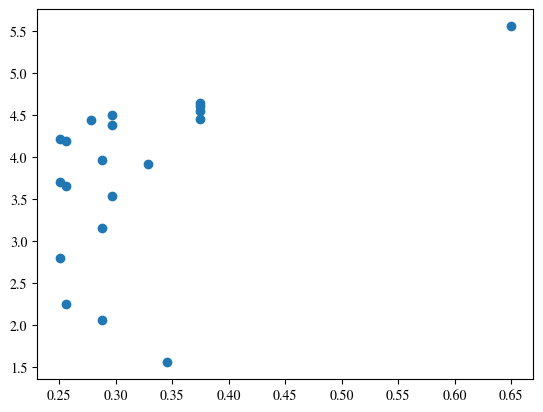

In [57]:
bins = pd.cut(all_Kd[all_Kd.ionic == 0.290].Rg, bins=20).value_counts()
lower, upper = bins.idxmax().left, bins.idxmax().right
test = all_Kd[(all_Kd.Rg > lower) & (all_Kd.Rg < upper)]
plt.scatter(test.kappa, np.log10(test.Kd))

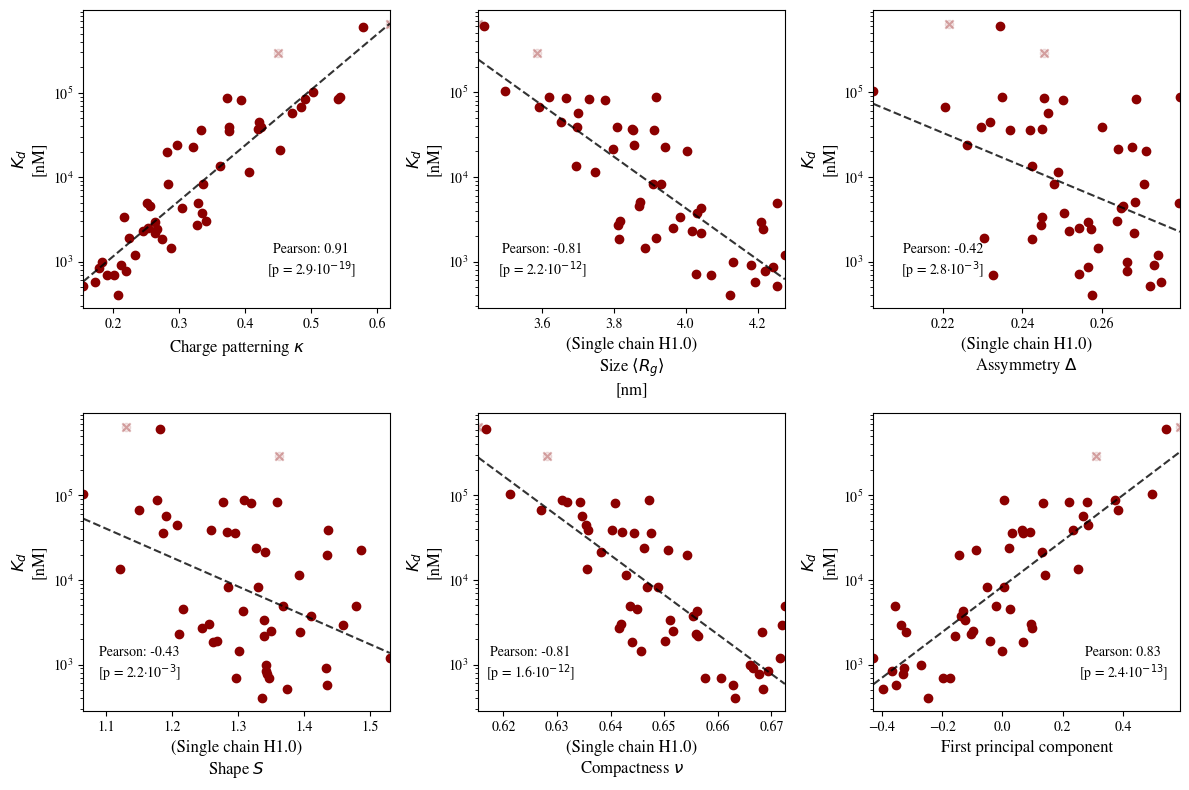

In [7]:
# Plotting results
plt.figure(figsize=(12,8))

# Kappa
plt.subplot(231)
plt.xlim(all_Kd.kappa.min(), all_Kd.kappa.max())
plt.xlabel("Charge patterning $\kappa$", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].kappa, all_Kd[~all_Kd.sampled_unbinding].Kd,  marker='x', color='darkred', alpha=0.3)
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].kappa, all_Kd[~all_Kd.sampled_unbinding].Kd, color='darkred', alpha=0.1)
plt.scatter(all_Kd[all_Kd.sampled_unbinding].kappa, all_Kd[all_Kd.sampled_unbinding].Kd, color='darkred')
corr, corr_p = pearsonr(all_Kd[all_Kd.sampled_unbinding].kappa, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd))
a, b = np.polyfit(all_Kd[all_Kd.sampled_unbinding].kappa, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd), 1)
plt.plot(np.linspace(*plt.xlim(), 100), 10**(a*np.linspace(*plt.xlim(), 100)+b), color='k', linestyle='--', alpha=0.8)
plt.text(0.5, 1000, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center', va='center')

# Rg
plt.subplot(232)
plt.xlim(all_Kd.Rg.min(), all_Kd.Rg.max())
plt.xlabel("(Single chain H1.0)\nSize $\left\langle R_g \\right\\rangle $\n[nm]", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].Rg, all_Kd[~all_Kd.sampled_unbinding].Kd,  marker='x', color='darkred', alpha=0.3)
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].Rg, all_Kd[~all_Kd.sampled_unbinding].Kd, color='darkred', alpha=0.1)
plt.scatter(all_Kd[all_Kd.sampled_unbinding].Rg, all_Kd[all_Kd.sampled_unbinding].Kd, color='darkred')
corr, corr_p = pearsonr(all_Kd[all_Kd.sampled_unbinding].Rg, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd))
a, b = np.polyfit(all_Kd[all_Kd.sampled_unbinding].Rg, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd), 1)
plt.plot(np.linspace(*plt.xlim(), 100), 10**(a*np.linspace(*plt.xlim(), 100)+b), color='k', linestyle='--', alpha=0.8)
plt.text(3.6, 1000, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center', va='center')

# Delta
plt.subplot(233)
plt.xlim(all_Kd.Delta.min(), all_Kd.Delta.max())
plt.xlabel("(Single chain H1.0)\nAssymmetry $\Delta$", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].Delta, all_Kd[~all_Kd.sampled_unbinding].Kd,  marker='x', color='darkred', alpha=0.3)
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].Delta, all_Kd[~all_Kd.sampled_unbinding].Kd, color='darkred', alpha=0.1)
plt.scatter(all_Kd[all_Kd.sampled_unbinding].Delta, all_Kd[all_Kd.sampled_unbinding].Kd, color='darkred')
corr, corr_p = pearsonr(all_Kd[all_Kd.sampled_unbinding].Delta, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd))
a, b = np.polyfit(all_Kd[all_Kd.sampled_unbinding].Delta, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd), 1)
plt.plot(np.linspace(*plt.xlim(), 100), 10**(a*np.linspace(*plt.xlim(), 100)+b), color='k', linestyle='--', alpha=0.8)
plt.text(0.22, 1000, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center', va='center')

# S
plt.subplot(234)
plt.xlim(all_Kd.S.min(), all_Kd.S.max())
plt.xlabel("(Single chain H1.0)\nShape $S$", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].S, all_Kd[~all_Kd.sampled_unbinding].Kd,  marker='x', color='darkred', alpha=0.3)
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].S, all_Kd[~all_Kd.sampled_unbinding].Kd, color='darkred', alpha=0.1)
plt.scatter(all_Kd[all_Kd.sampled_unbinding].S, all_Kd[all_Kd.sampled_unbinding].Kd, color='darkred')
corr, corr_p = pearsonr(all_Kd[all_Kd.sampled_unbinding].S, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd))
a, b = np.polyfit(all_Kd[all_Kd.sampled_unbinding].S, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd), 1)
plt.plot(np.linspace(*plt.xlim(), 100), 10**(a*np.linspace(*plt.xlim(), 100)+b), color='k', linestyle='--', alpha=0.8)
plt.text(1.15, 1000, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center', va='center')

# nu
plt.subplot(235)
plt.xlim(all_Kd.nu.min(), all_Kd.nu.max())
plt.xlabel("(Single chain H1.0)\nCompactness $\\nu$", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].nu, all_Kd[~all_Kd.sampled_unbinding].Kd,  marker='x', color='darkred', alpha=0.3)
plt.scatter(all_Kd[~all_Kd.sampled_unbinding].nu, all_Kd[~all_Kd.sampled_unbinding].Kd, color='darkred', alpha=0.1)
plt.scatter(all_Kd[all_Kd.sampled_unbinding].nu, all_Kd[all_Kd.sampled_unbinding].Kd, color='darkred')
corr, corr_p = pearsonr(all_Kd[all_Kd.sampled_unbinding].nu, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd))
a, b = np.polyfit(all_Kd[all_Kd.sampled_unbinding].nu, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd), 1)
plt.plot(np.linspace(*plt.xlim(), 100), 10**(a*np.linspace(*plt.xlim(), 100)+b), color='k', linestyle='--', alpha=0.8)
plt.text(0.625, 1000, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center', va='center')

# First principal component
pca_pcs = pd.DataFrame(PCA().fit_transform(all_Kd[['kappa', 'Rg', 'Delta', 'S', 'nu']]), columns=[f'PC{i+1}' for i in range(len(['kappa', 'Rg', 'Delta', 'S', 'nu']))], index=all_Kd.index)
plt.subplot(236)
plt.xlim(pca_pcs.PC1.min(), pca_pcs.PC1.max())
plt.xlabel("First principal component", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.scatter(pca_pcs[~all_Kd.sampled_unbinding].PC1, all_Kd[~all_Kd.sampled_unbinding].Kd,  marker='x', color='darkred', alpha=0.3)
plt.scatter(pca_pcs[~all_Kd.sampled_unbinding].PC1, all_Kd[~all_Kd.sampled_unbinding].Kd, color='darkred', alpha=0.1)
plt.scatter(pca_pcs[all_Kd.sampled_unbinding].PC1, all_Kd[all_Kd.sampled_unbinding].Kd, color='darkred')
corr, corr_p = pearsonr(pca_pcs[all_Kd.sampled_unbinding].PC1, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd))
a, b = np.polyfit(pca_pcs[all_Kd.sampled_unbinding].PC1, np.log10(all_Kd[all_Kd.sampled_unbinding].Kd), 1)
plt.plot(np.linspace(*plt.xlim(), 100), 10**(a*np.linspace(*plt.xlim(), 100)+b), color='k', linestyle='--', alpha=0.8)
plt.text(0.4, 1000, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center', va='center')

plt.tight_layout()


,Kd,kappa,Rg,Delta,S,nu
Kd,1.000000,0.914693,-0.836544,-0.465257,-0.439395,-0.838595
kappa,0.914693,1.000000,-0.863267,-0.495889,-0.507487,-0.863631
Rg,-0.836544,-0.863267,1.000000,0.667249,0.699716,0.992211
Delta,-0.465257,-0.495889,0.667249,1.000000,0.717262,0.631695
S,-0.439395,-0.507487,0.699716,0.717262,1.000000,0.695082
nu,-0.838595,-0.863631,0.992211,0.631695,0.695082,1.000000


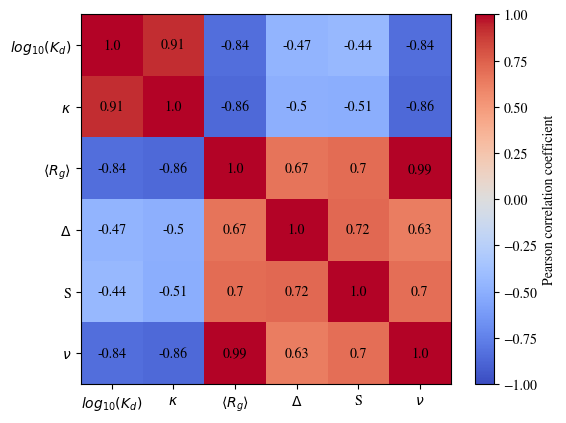

In [8]:
all_Kd_num = all_Kd[['Kd', 'kappa', 'Rg', 'Delta', 'S', 'nu']].copy()
all_Kd_num['Kd'] = np.log10(all_Kd_num.Kd)
all_corr = all_Kd_num.corr()
plt.imshow(all_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(np.linspace(0,5,6), labels=['$log_{10}(K_d)$', '$\kappa$', '$\left\langle R_g \\right\\rangle$', '$\Delta$', 'S', '$\\nu$'])
plt.yticks(np.linspace(0,5,6), labels=['$log_{10}(K_d)$', '$\kappa$', '$\left\langle R_g \\right\\rangle$', '$\Delta$', 'S', '$\\nu$'])
for col in range(6):
    for row in range(6):
        plt.text(col, row, round(all_corr.iloc[row, col],2), ha='center', va='center')
plt.colorbar(label='Pearson correlation coefficient')
all_corr

In [85]:
# Fitting general linear models
import statsmodels.api as sm

y = np.log10(all_Kd.Kd)
x = pd.concat([np.log(all_Kd.ionic), all_Kd.kappa, all_Kd.Rg, all_Kd.Delta, all_Kd.S, all_Kd.nu], axis=1)

model = sm.OLS(y, sm.add_constant(x))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Kd   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     36.62
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           2.51e-30
Time:                        21:57:45   Log-Likelihood:                -284.84
No. Observations:                 220   AIC:                             583.7
Df Residuals:                     213   BIC:                             607.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3687     12.080     -0.113      0.910     -25.180      22.443
ionic          2.3497      0.377      6.235      0.000       1.607       3.092
kappa          5.2869      0.634      8.341      0.000       4.037       6.536
Rg            -1.1690      2.167     -0.539      0.590      -5.442       3.103
Delta         -6.0725      5.429     -1.118      0.265     -16.775       4.630
S              0.8625      1.043      0.827      0.409      -1.194       2.919
nu            17.6316     31.065      0.568      0.571     -43.603      78.867
==============================================================================
Omnibus:                       49.245   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.989
Skew:                           0.939   Prob(JB):                     1.47e-31
Kurtosis:                       6.459   Cond. No.                     2.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, '$\\left\\langle R_g \\right\\rangle$\n[nm]')

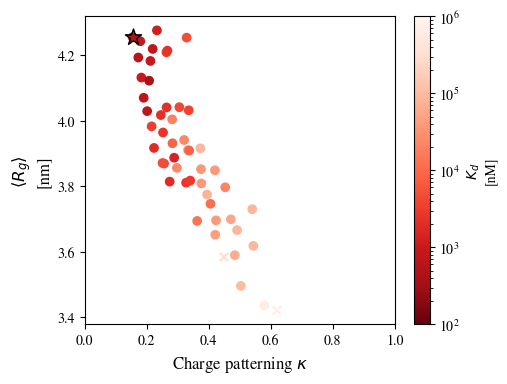

In [98]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(5,4))
all_Kd_290 = all_Kd[all_Kd.ionic==0.290]
plt.scatter(all_Kd_290[~all_Kd_290.sampled_unbinding].kappa, all_Kd_290[~all_Kd_290.sampled_unbinding].Rg, marker='x', c=all_Kd_290[~all_Kd_290.sampled_unbinding].Kd, norm=LogNorm(vmin=100, vmax=1e6), cmap='Reds_r')
plt.scatter(all_Kd_290[all_Kd_290.sampled_unbinding].kappa, all_Kd_290[all_Kd_290.sampled_unbinding].Rg, c=all_Kd_290[all_Kd_290.sampled_unbinding].Kd, norm=LogNorm(vmin=100, vmax=1e6), cmap='Reds_r')
plt.colorbar(label='$K_d$\n[nM]')
plt.scatter(all_Kd.loc[93].kappa, all_Kd.loc[93].Rg, marker='*', c=all_Kd.loc[93].Kd, norm=LogNorm(vmin=100, vmax=1e6), cmap='Reds_r', edgecolor='black', s=150)
plt.xlabel('Charge patterning $\kappa$', fontsize=12)
plt.xlim(0,1)
plt.ylabel('$\left\langle R_g \\right\\rangle$\n[nm]', fontsize=12)

In [118]:
table = all_Kd[['kappa', 'Rg', 'ionic', 'Kd', 'seq']].sort_values(['kappa', 'Rg'])
table.ionic *= 1e3
table.kappa = table.kappa.round(3)
table.Rg = table.Rg.round(2)
table.ionic = table.ionic.round(0).astype(int)
table.Kd = table.Kd.round(0).astype(int)

table.to_csv('kd_results.csv', index=False)